<a href="https://colab.research.google.com/github/veljkolazic17/PRS/blob/main/PRS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Analiza

In [13]:
K = [2,3,4,5]

In [14]:
def calculate_lambda(P : np.array) -> np.array:
  # Calculate P transposed
  PT = P.transpose()
  # Calculate Inverse matrix
  I = np.identity(P.shape[0])
  # Calculate A
  A = np.zeros(P.shape[0])
  A[0] = 1

  # Calculate lambda vector
  L = np.matmul(np.linalg.inv(np.subtract(I, PT)), A)
  return L

K = 2 : Critical resource is user disk 1
K = 3 : Critical resource is processor
K = 4 : Critical resource is processor
K = 5 : Critical resource is processor


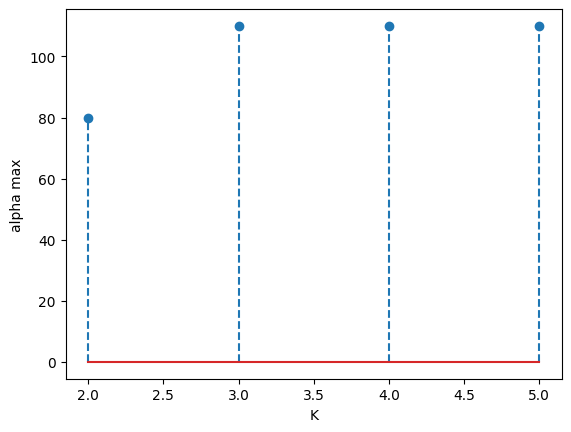

In [15]:
# Define S vector without K disks
S = np.array([0.00625, 0.01, 0.015, 0.015])

# Write to file L/A
P = np.array([[0.2, 0.15, 0.1, 0.05],
                [0.3,  0.2,   0,    0],
                [0.3,    0, 0.2,    0],
                [0.3,    0,   0,  0.2]])

f = open('protoci_analiticki', 'w+')

a_max_arr = []
r_arr = [0.25, 0.50, 0.77, 0.99]
LRes_arr = []

for k in K:
  # Extend P matrix with probabilities of user disks
  P_prim = P
  S_prim = S

  P_prim = np.append(P, np.full([P.shape[0], k], 0.5/k) , axis = 1)
  P_prim = np.r_[P_prim, np.zeros([k, k + P_prim.shape[0]])]
  # Write to a file
  LRes = calculate_lambda(P_prim)
  LRes_arr.append(LRes)

  S_prim = np.append(S, np.full([k], 0.025))

  U_prim = np.multiply(LRes, S_prim)

  index = np.argmax(U_prim)
  if(index == 0):
    print("K = %d : Critical resource is processor" % k)
  elif index < 4:
    print("K = %d : Critical resource is system disk %d" % (k, index))
  else:
    print("K = %d : Critical resource is user disk %d" % (k, index - 3))



  a_max = (1/S_prim[index])/LRes[index]
  a_max_arr.append(a_max)

  f.write('K = ' + str(k) + '-'*64 + '\n' + np.array2string(LRes) + '\n')

f.close()

plt.stem(K, a_max_arr, linefmt='--')
plt.xlabel("K")
plt.ylabel("alpha max")

plt.show()


In [16]:
f = open('rezultati_analiticki', 'w+')

for ida, a in enumerate(a_max_arr):
  for r in r_arr:
    LRes = np.array(LRes_arr[ida])

    V = LRes

    LRes = LRes * a * r

    S_prim = S
    S_prim = np.append(S, np.full([ida + 2], 0.025))

    U_prim = np.multiply(LRes, S_prim)
    U_prim_inv = np.ones([LRes.size]) - U_prim

    J = np.divide(U_prim, U_prim_inv)
    R = np.divide(J, LRes)

    R_system = np.sum(V * R)

    file_line = 'K = ' + str(ida+2) + '; lambda = ' + str(a*r) + '\nU = \t' + str(U_prim) + '\nJ = \t' + str(J) + '\nR = \t' + str(R) + '\nR_system = \t' + str(R_system) + '\n' + '-'*64 + '\n'
    f.write(file_line)

f.close()

In [17]:
import threading
import random
import time

# Simualcija iterativno

In [18]:
class Server ():

    name : str
    visited : int
    queue : int
    speed : float
    work_left : float
    next_server = []
    next_probability = ()

    def __init__(self, servers, name, speed, next_server = [], next_probability = []):
        self.name = name
        self.speed = speed
        self.next_server = next_server
        self.next_probability = next_probability
        self.servers = servers
        self.servers[name] = self
        self.queue = 0
        self.visited = 0


    def add_to_queue(self):
        self.queue += 1

    def call(self):
        if self.queue != 0:
            if self.work_left > 0:
                self.work_left -= 1
            else:
                self.visited += 1
                self.queue -= 1
                if len(self.next_server) != 0:
                    next = random.choices(self.next_server, self.next_probability, k=1)
                    self.servers[next[0]].add_to_queue()
                self.work_left = self.speed
        else:
            self.work_left = self.speed

In [19]:
results = {}
lock = threading.Lock()

def thread_job(k, alpha, time):
  servers = {}

  user_disks = []
  user_disk_probabilities = [0.5/k] * k
  for i in range(k):
    user_disk = Server(servers, 'UserDisk' + str(i+1), 25)
    user_disks.append(user_disk.name)
  Server(servers, 'SystemDisk1', 10, user_disks + ['SystemDisk1', 'CPU'], user_disk_probabilities + [0.2, 0.3])
  Server(servers, 'SystemDisk2', 15, user_disks + ['SystemDisk2', 'CPU'], user_disk_probabilities + [0.2, 0.3])
  Server(servers, 'SystemDisk3', 15, user_disks + ['SystemDisk3', 'CPU'], user_disk_probabilities + [0.2, 0.3])
  Server(servers, 'CPU', 6.25, user_disks + ['SystemDisk1', 'SystemDisk2', 'SystemDisk3', 'CPU'], user_disk_probabilities + [0.15, 0.1, 0.05, 0.2])

  counter = 0
  number_of_jobs = 0
  time = time

  while time >= 0:
      counter += 1

      if counter == 1000//20:
          counter = 0
          servers['CPU'].add_to_queue()
          number_of_jobs += 1

      time -= 1

      for server in servers:
          servers[server].call()

  V_ = [servers['CPU'].visited/number_of_jobs,
      servers['SystemDisk1'].visited/number_of_jobs,
      servers['SystemDisk2'].visited/number_of_jobs,
      servers['SystemDisk3'].visited/number_of_jobs]
  for server in user_disks:
    V_.append(servers[server].visited/number_of_jobs)

  V = np.array(V_)
  L = V * alpha

  S_prim = S
  S_prim = np.append(S, np.full([k], 0.025))

  U = np.multiply(L, S_prim)
  U_inv = np.ones([L.size]) - U

  J = np.divide(U, U_inv)
  R = np.divide(J, L)

  R_system = np.sum(V * R)

  key = 'k' + str(k) + 'a' + str(round(alpha))
  file_line = key + '\nU = \t' + str(U) + '\nJ = \t' + str(J) + '\nR = \t' + str(R) + '\nR_system = \t' + str(R_system) + '\n' + '-'*64 + '\n'
  print(file_line)

  with lock:
    results[key].append([L, U, J, R, R_system])

  # print('Finished K = ' + str(k) + '; alpha = ' + str(alpha))


In [20]:
time = 1800000
cycles = 1

threads = []
for i in range(cycles):
  for ida, a in enumerate(a_max_arr):
    for r in r_arr:
      key = 'k' + str(ida + 2) + 'a' + str(round(a * r))
      if not (key in results):
        results[key] = []
      thread = threading.Thread(target=thread_job, args=(ida+2, a * r, time, ))
      thread.start()
      threads.append(thread)

  for thread in threads:
    thread.join()

f = open('rezultati_simulacija','w+')

for key in results:
  res_arr = results[key]
  L = np.zeros(res_arr[0][0].size)
  U = np.zeros(res_arr[0][1].size)
  J = np.zeros(res_arr[0][2].size)
  R = np.zeros(res_arr[0][3].size)
  R_system = 0
  for iteration in res_arr:
    #Calculate L
    L += iteration[0]

    #Calculate U
    U += iteration[1]

    #Calculate J
    J += iteration[2]

    #Calculate R
    R += iteration[3]

    #Calculate R_system
    R_system += iteration[4]

  L /= cycles
  U /= cycles
  J /= cycles
  R /= cycles
  R_system /= cycles

  file_line = key + '\nU = \t' + str(U) + '\nJ = \t' + str(J) + '\nR = \t' + str(R) + '\nR_system = \t' + str(R_system) + '\n' + '-'*64 + '\n'
  f.write(file_line)

f.close()

k2a20
U = 	[0.18164236 0.05565556 0.05436667 0.026575   0.24894444 0.25104167]
J = 	[0.22195963 0.05893565 0.05749233 0.02730051 0.33145943 0.33518776]
R = 	[0.00763725 0.01058936 0.01586238 0.01540951 0.03328649 0.03337969]
R_system = 	0.051616765871353394
----------------------------------------------------------------

k2a79
U = 	[0.719455 0.213048 0.210276 0.108372 0.99528  0.984665]
J = 	[2.56449055e+00 2.70725533e-01 2.66265176e-01 1.21543962e-01
 2.10864407e+02 6.42103032e+01]
R = 	[0.02227807 0.01270726 0.01899398 0.01682316 5.29661017 1.63025758]
R_system = 	3.513860293241125
----------------------------------------------------------------

k2a62
U = 	[0.56087014 0.16734667 0.16904067 0.082236   0.76465278 0.77530444]
J = 	[1.2772307  0.20098    0.20342833 0.08960473 3.24904102 3.45046631]
R = 	[0.01423269 0.0120098  0.01805142 0.01634407 0.10622603 0.11126166]
R_system = 	0.1375121929221435
----------------------------------------------------------------
k2a40
U = 	[0.3648333